In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

from src.utils.time_series_procs import split_sequences
from src.models.transformer_ts_tf import Transformer

In [2]:
def plot_time_series_train_and_prediction_windows(df, model, cut_date):
    index = df['Data/Hora'].shape[0] - df[df['Data/Hora'] == cut_date].index[0] 
    index = -index
    y = df['R28D'].values
    d = df['Data/Hora'].values
    test_series = pd.DataFrame({'ccs28':y}, index=pd.to_datetime(d))
    pred_series = model.predict(x_test)
    pred_series = pd.DataFrame({'ccs28-pred' : pred_series.squeeze()}, index=pd.to_datetime(d[index+2:]))

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color='r') # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(["train and test series", "end of train series", 'predicted'], loc="upper left")
    # ax.set_xlabel('Period', labelpad=20, fontsize=15)
    ax.set_ylabel('Compressive Strength - MPa', labelpad=20, fontsize=15)
    plt.show()

In [3]:
def get_times_series_data(df, cut_date):
    columns = list(df.columns.drop(['R28D']))
    columns.append('R28D')
    df = df.reindex(columns=columns)
    df['Data/Hora'] = pd.to_datetime(df['Data/Hora'])
    df_train = df[df['Data/Hora'] < cut_date]
    df_test = df[df['Data/Hora'] >= cut_date]
    df_train = df_train.drop(['Data/Hora'], axis=1)
    df_test = df_test.drop(['Data/Hora'], axis=1)
    x_train, y_train = split_sequences(df_train.values, TIME_STEPS)
    x_test, y_test = split_sequences(df_test.values, TIME_STEPS)
    return x_train, y_train, x_test, y_test

In [4]:
class StandardScaler3DShape():
    def __init__(self):
        self.scaler = StandardScaler()
    def fit_transform(self,X, y=None):
        X_new = self.scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new
        
    def fit(self,X, y=None):
        X_new = X.reshape(-1, X.shape[-1])
        self.scaler.fit(X_new)
        return self
    
    def transform(self,X,y=None):
        X_new = self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

<h3>Force tensorflow use CPU only</h3>

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

<h3>Disable Tensorflow Warnings</h3>

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [7]:
name = "dados-historicos-partner_i-cement-CPIIF40.csv"
df_r3d_and_r7d = pd.read_csv("../../data/interim/" + "r3d-and-r7d-" + name)
df_r3d_only = pd.read_csv("../../data/interim/" + "r3d-only-" + name)
df_no_r3d_r7d = pd.read_csv("../../data/interim/" + "no-r3d-r7d-" + name)

In [8]:
seed = 47
scaler = StandardScaler()

In [9]:
cut_date = '2021-05-02'
TIME_STEPS = 3

# Transformer Encoder

# Baseline models

First we will train a baseline model and verify its overall performance on each of the three datasets.

# Configs:

1. Train Period: [01-01-2019, 2021-05-02)

2. Test Period:  (2021-05-02, 2021-11-31]

3. TIMESTEPS: [1, 3, 5, 7, 10, 15, 20]

4. Epochs: 100

5. Batch size: 32

6. num heads: 2

7. FF Layers enc: 1

      7.1 Units 32

8. Optimization Algorithm: Adam
    
    8.1. Learning Rate: 1e-2

In [10]:
def get_baseline_model(num_features, time_steps, num_heads=2, num_layers_enc=1, num_feed_forward=32):
    model = Transformer(num_hid=num_features,
                        time_steps=time_steps,
                        num_head=num_heads,
                        num_layers_enc=num_layers_enc,
                        num_feed_forward=num_feed_forward)

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

<h3> Baseline model - Dataset: df_no_r3d_r7d</h3>

In [11]:
df = df_no_r3d_r7d.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [12]:
model = get_baseline_model(num_features=x_train.shape[-1], time_steps=x_train.shape[-2])
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 2.145


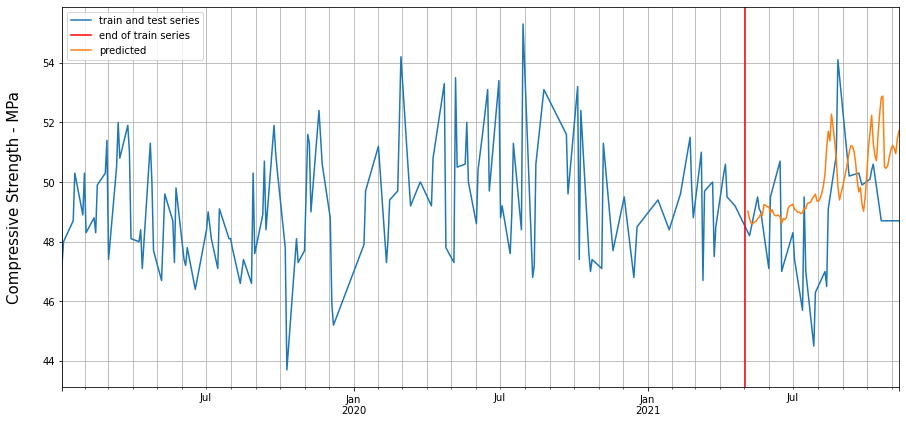

In [13]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

<h3> Baseline model - Dataset: df_r3d_only</h3>

In [14]:
df = df_r3d_only.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [15]:
model = get_baseline_model(num_features=x_train.shape[-1], time_steps=x_train.shape[-2])
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 2.103


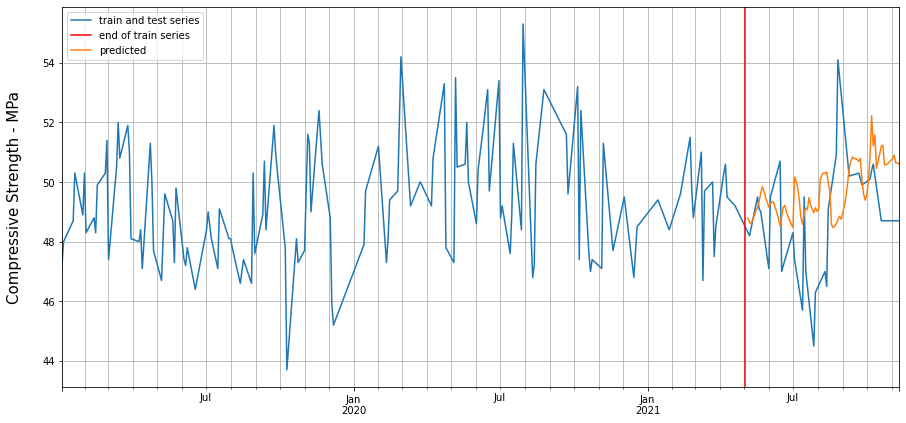

In [16]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

<h3> Baseline model - Dataset: df_r3d_and_r7d</h3>

In [17]:
df = df_r3d_and_r7d.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [18]:
model = get_baseline_model(num_features=x_train.shape[-1], time_steps=x_train.shape[-2])
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 2.427


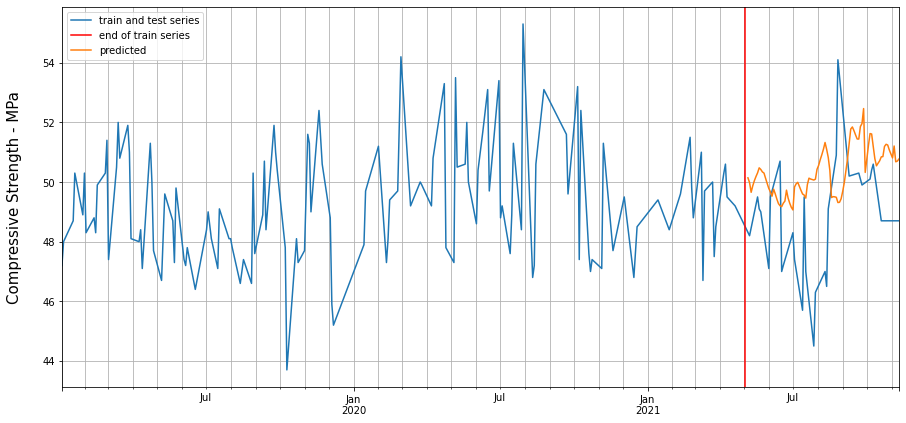

In [19]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

# Grid Search CV

Before doing Repeated Cross Validation, we shall search for the best parameters. To do so, Keras Tuner will be used
to accomplish the Grid Search.

<h3>GridCV - Scikit Learn</h3>

In [20]:
def create_keras_model(num_features,
                       time_steps,
                       num_heads=2,
                       num_layers_enc=1,
                       num_feed_forward=32,
                       activation='relu',
                       dropout_rate=0.0,
                       learning_rate=1e-3):
    
    model = Transformer(num_hid=num_features,
                        time_steps=time_steps,
                        num_head=num_heads,
                        num_layers_enc=num_layers_enc,
                        num_feed_forward=num_feed_forward,
                        activation=activation,
                        dropout_rate=dropout_rate)
                        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

In [21]:
def make_grid_search(x, y, TIME_STEPS):
    activation = ['selu', 'relu', 'swish']
    dropout_rate = [0.0, 0.1]
    num_heads = [1, 2, 3,]
    num_layers_enc = [1, 2, 3]
    num_feed_forward = [32]
    learning_rate = [0.001, 0.01, 0.1]
    epochs = [100]
    batches = [32]
    time_steps = [TIME_STEPS]
    num_features = [x.shape[-1]]

    param_grid = dict(model__time_steps=time_steps,
                      model__num_features=num_features,
                      model__num_heads=num_heads,
                      model__num_feed_forward=num_feed_forward,
                      model__num_layers_enc=num_layers_enc,
                      model__activation=activation,
                      model__dropout_rate=dropout_rate, 
                      model__learning_rate=learning_rate,
                      model__epochs=epochs,
                      model__batch_size=batches)

    model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)
    pipeline = Pipeline(steps=[('transformer', StandardScaler3DShape()), ('model', model)])

    grid = GridSearchCV(estimator=pipeline, 
                        param_grid=param_grid,
                        n_jobs=-1,
                        cv=3, 
                        scoring='neg_root_mean_squared_error')
    
    grid_result = grid.fit(x, y)

    print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid

<h3>GridCV 1</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [22]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv1 = make_grid_search(x, y, TIME_STEPS)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_1707827/3579517416.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)


Best: -1.775438 using {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.1, 'model__num_features': 34, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 3, 'model__time_steps': 3}

-2.337093 (0.843436) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 34, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 1, 'model__time_steps': 3}
-2.021080 (0.410512) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 34, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 2, 'model__time_steps': 3}
-2.130343 (0.692179) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__

In [23]:
gridcv1.best_params_

{'model__activation': 'relu',
 'model__batch_size': 32,
 'model__dropout_rate': 0.0,
 'model__epochs': 100,
 'model__learning_rate': 0.1,
 'model__num_features': 34,
 'model__num_feed_forward': 32,
 'model__num_heads': 1,
 'model__num_layers_enc': 3,
 'model__time_steps': 3}

<h3>GridCV 2</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D is considered.

In [24]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv2 = make_grid_search(x, y, TIME_STEPS)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_1707827/3579517416.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)


Best: -1.712042 using {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.01, 'model__num_features': 35, 'model__num_feed_forward': 32, 'model__num_heads': 3, 'model__num_layers_enc': 2, 'model__time_steps': 3}

-1.998476 (0.419293) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 35, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 1, 'model__time_steps': 3}
-1.945666 (0.328532) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 35, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 2, 'model__time_steps': 3}
-1.914581 (0.335149) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model_

In [25]:
gridcv2.best_params_

{'model__activation': 'relu',
 'model__batch_size': 32,
 'model__dropout_rate': 0.0,
 'model__epochs': 100,
 'model__learning_rate': 0.01,
 'model__num_features': 35,
 'model__num_feed_forward': 32,
 'model__num_heads': 3,
 'model__num_layers_enc': 2,
 'model__time_steps': 3}

<h3>GridCV 3</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset R3D and R7D are considered.

In [26]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv3 = make_grid_search(x, y, TIME_STEPS)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_1707827/3579517416.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)


Best: -1.685099 using {'model__activation': 'swish', 'model__batch_size': 32, 'model__dropout_rate': 0.1, 'model__epochs': 100, 'model__learning_rate': 0.1, 'model__num_features': 36, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 2, 'model__time_steps': 3}

-1.884339 (0.334295) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 36, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 1, 'model__time_steps': 3}
-1.934701 (0.355428) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 36, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 2, 'model__time_steps': 3}
-1.895997 (0.355205) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model_

In [27]:
gridcv3.best_params_

{'model__activation': 'swish',
 'model__batch_size': 32,
 'model__dropout_rate': 0.1,
 'model__epochs': 100,
 'model__learning_rate': 0.1,
 'model__num_features': 36,
 'model__num_feed_forward': 32,
 'model__num_heads': 1,
 'model__num_layers_enc': 2,
 'model__time_steps': 3}

<h2>Times Series KFold Cross validation - Non Canonical Transformer</h2>

Here we will make a Times Series KFold Cross validation with all 3 datasets. Here we are using the <b>Blocking           Time Series Split</b> method. And with timeseries Split method

In [28]:
def make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, grid, repeats=10):
    results = []
    max_samples = x.shape[0]

    activation = grid.best_params_['model__activation']
    dropout_rate = grid.best_params_['model__dropout_rate']
    num_feed_forward = grid.best_params_['model__num_feed_forward']
    num_layers_enc = grid.best_params_['model__num_layers_enc']
    learning_rate = grid.best_params_['model__learning_rate']
    batch_size = grid.best_params_['model__batch_size']
    epochs = grid.best_params_['model__epochs']
    time_steps = grid.best_params_['model__time_steps']
    num_features = grid.best_params_['model__num_features']
    num_heads = grid.best_params_['model__num_heads']
    
    for _ in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples//train_period):
            x_train = x[i:i+train_period]
            y_train = y[i:i+train_period]
            x_test = x[i+train_period: i+train_period+test_period]
            y_test = y[i+train_period: i+train_period+test_period]
            i += train_period
            x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
            x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
            model = Transformer(num_hid=num_features,
                                time_steps=time_steps,
                                num_head=num_heads,
                                num_layers_enc=num_layers_enc,
                                num_feed_forward=num_feed_forward,
                                activation=activation,
                                dropout_rate=dropout_rate)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss="mse",
                          metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
            model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            rmse = model.evaluate(x_test, y_test, verbose=0)
            scores.append(rmse[1])
        results.append(scores)
        print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

    print('\nRMSE: %.3f (%.3f)' % (np.mean(results), np.std(results)))
    return results

<h3> Time Series Repeated KFold Cross Validation Non Canonical Transformer - df_no_r3d_r7d</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [29]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [30]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 1.552 (0.571)
RMSE: 1.536 (0.580)
RMSE: 1.547 (0.520)
RMSE: 1.536 (0.469)
RMSE: 1.460 (0.663)
RMSE: 1.380 (0.629)
RMSE: 1.484 (0.605)
RMSE: 1.512 (0.547)
RMSE: 1.526 (0.455)
RMSE: 1.486 (0.522)

RMSE: 1.502 (0.562)


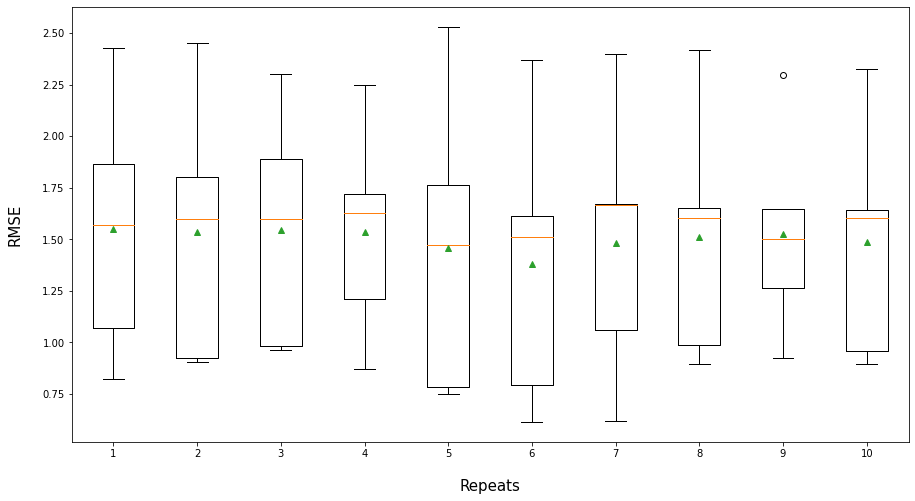

In [31]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [32]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 1.847 (1.061)
RMSE: 2.382 (0.871)
RMSE: 1.786 (0.728)
RMSE: 1.700 (0.125)
RMSE: 1.898 (0.420)
RMSE: 1.783 (0.781)
RMSE: 2.580 (0.667)
RMSE: 2.612 (0.118)
RMSE: 1.873 (1.083)
RMSE: 1.893 (0.601)

RMSE: 2.035 (0.794)


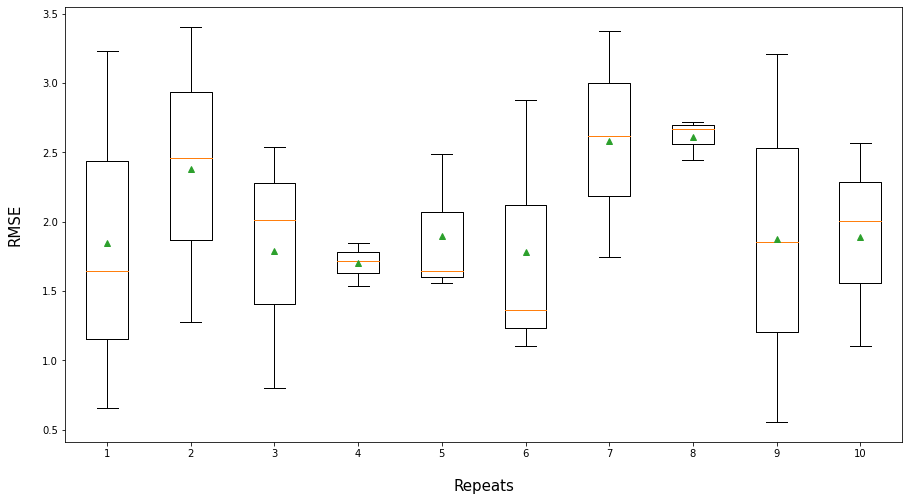

In [33]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [34]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 0.728 (0.000)
RMSE: 0.743 (0.000)
RMSE: 0.952 (0.000)
RMSE: 0.872 (0.000)
RMSE: 1.097 (0.000)
RMSE: 1.388 (0.000)
RMSE: 0.928 (0.000)
RMSE: 1.649 (0.000)
RMSE: 1.248 (0.000)
RMSE: 0.946 (0.000)

RMSE: 1.055 (0.279)


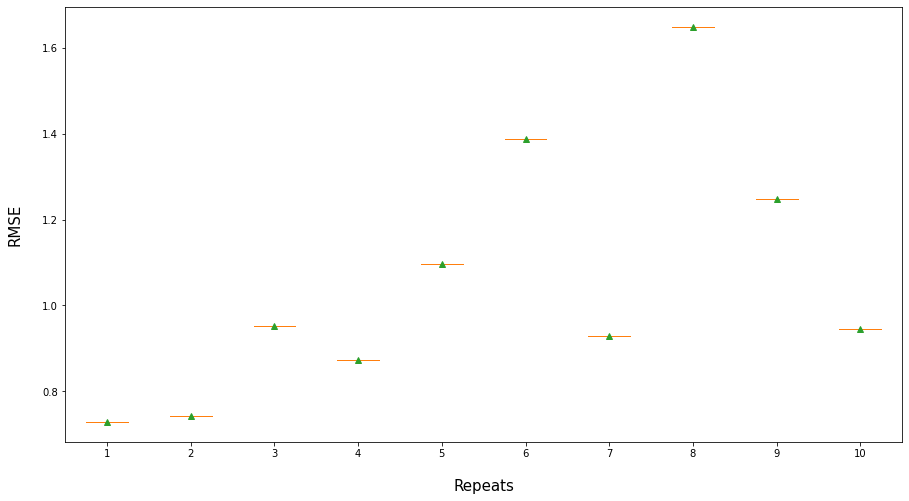

In [35]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_only</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D variable is considered.

In [36]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [37]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 1.496 (0.546)
RMSE: 1.420 (0.654)
RMSE: 1.410 (0.643)
RMSE: 1.457 (0.606)
RMSE: 1.414 (0.636)
RMSE: 1.382 (0.680)
RMSE: 1.609 (0.485)
RMSE: 1.468 (0.599)
RMSE: 1.384 (0.706)
RMSE: 1.399 (0.586)

RMSE: 1.444 (0.620)


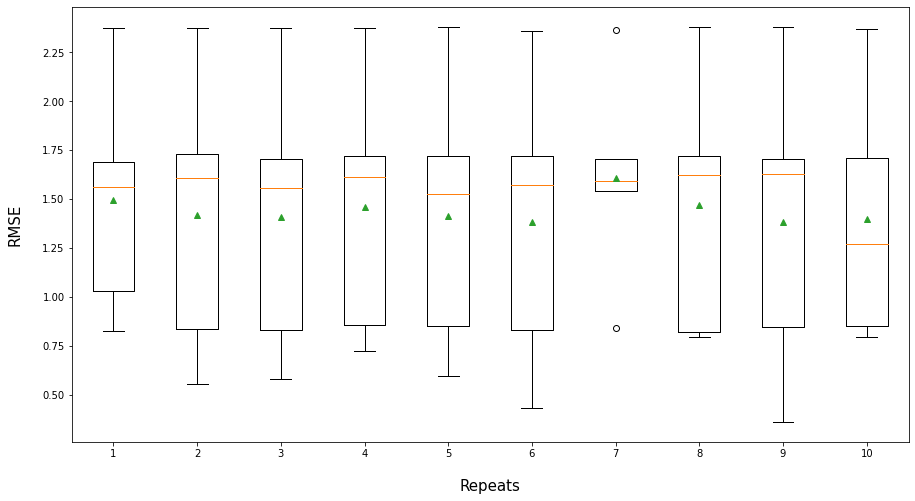

In [38]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [39]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 2.056 (0.639)
RMSE: 1.950 (0.638)
RMSE: 1.723 (0.239)
RMSE: 1.470 (0.605)
RMSE: 1.776 (0.575)
RMSE: 1.520 (0.766)
RMSE: 1.705 (0.804)
RMSE: 1.430 (0.529)
RMSE: 1.862 (0.723)
RMSE: 1.566 (0.942)

RMSE: 1.706 (0.699)


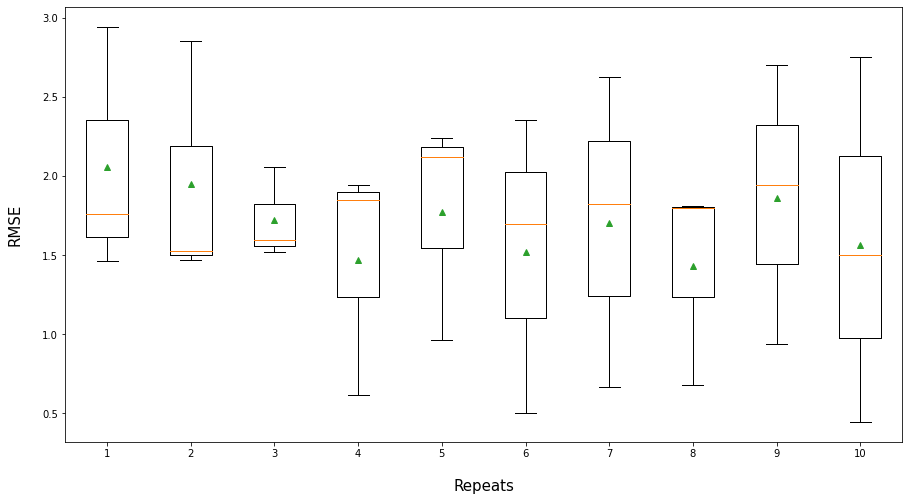

In [40]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [41]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 0.700 (0.000)
RMSE: 1.248 (0.000)
RMSE: 1.659 (0.000)
RMSE: 0.866 (0.000)
RMSE: 0.875 (0.000)
RMSE: 1.115 (0.000)
RMSE: 0.639 (0.000)
RMSE: 1.010 (0.000)
RMSE: 0.993 (0.000)
RMSE: 1.243 (0.000)

RMSE: 1.035 (0.285)


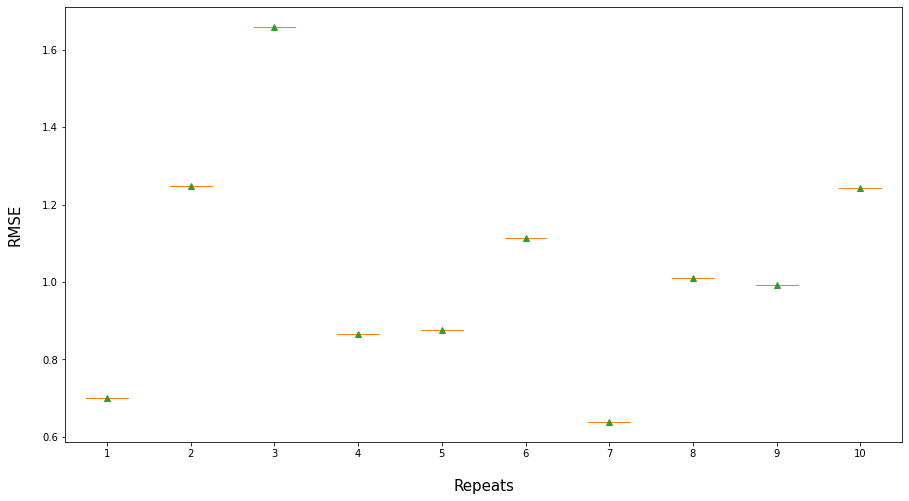

In [42]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_and_r7d</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [43]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [44]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 2.608 (0.816)
RMSE: 2.496 (0.717)
RMSE: 2.736 (0.724)
RMSE: 2.279 (0.804)
RMSE: 2.569 (0.725)
RMSE: 2.381 (0.856)
RMSE: 2.680 (0.679)
RMSE: 2.476 (0.806)
RMSE: 2.569 (0.744)
RMSE: 2.543 (0.760)

RMSE: 2.534 (0.775)


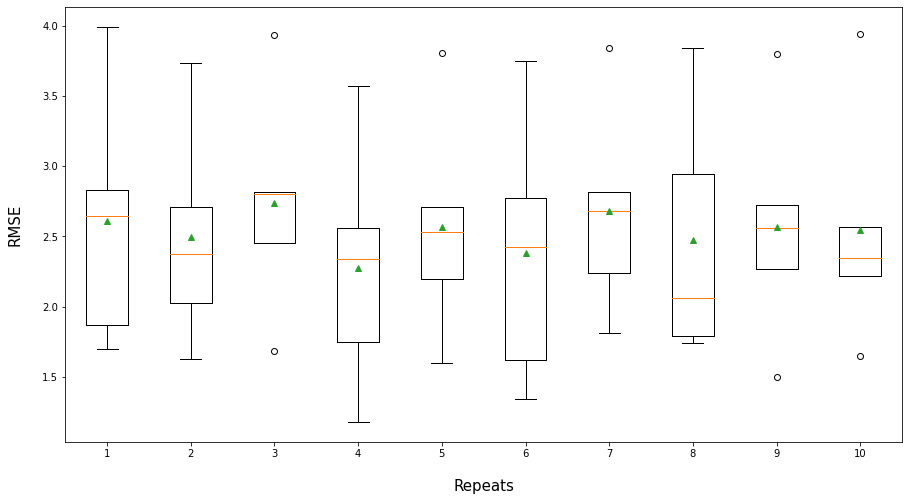

In [45]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [46]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 3.462 (1.661)
RMSE: 2.542 (1.735)
RMSE: 3.173 (1.190)
RMSE: 3.109 (1.145)
RMSE: 3.412 (1.061)
RMSE: 2.505 (1.713)
RMSE: 3.125 (1.827)
RMSE: 3.380 (0.187)
RMSE: 2.300 (1.502)
RMSE: 2.866 (1.530)

RMSE: 2.987 (1.486)


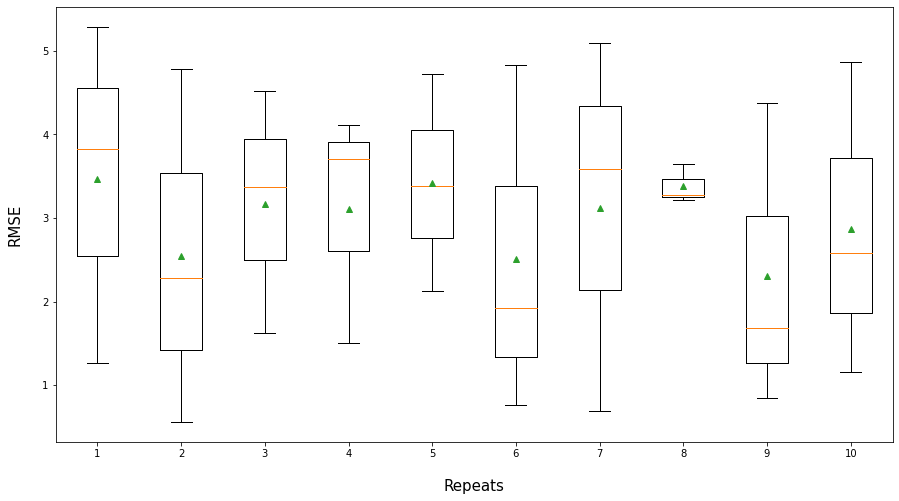

In [47]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [48]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 1.507 (0.000)
RMSE: 1.364 (0.000)
RMSE: 3.544 (0.000)
RMSE: 1.884 (0.000)
RMSE: 2.094 (0.000)
RMSE: 2.903 (0.000)
RMSE: 2.245 (0.000)
RMSE: 3.539 (0.000)
RMSE: 0.846 (0.000)
RMSE: 0.761 (0.000)

RMSE: 2.069 (0.955)


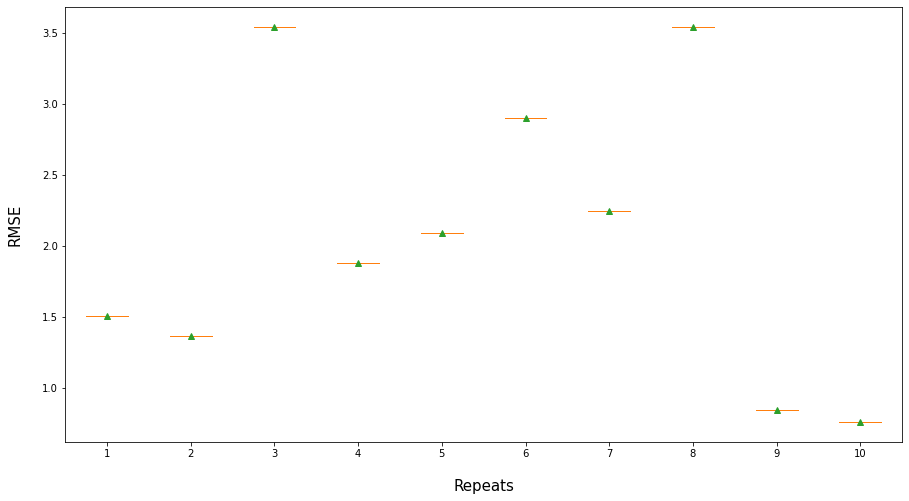

In [49]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h2>Times Series KFold Cross validation - Canonical Transformer</h2>

Here we will make a Times Series KFold Cross validation with all 3 datasets. Here we are using the <b>Blocking           Time Series Split</b> method. And with timeseries Split method

In [50]:
def make_repeated_time_series_k_fold(x, 
                                     y, 
                                     train_period,
                                     test_period,
                                     repeats=10,
                                     show_individual_results=True,
                                     show_final_result=True):
    results = []
    max_samples = x.shape[0]

    for _ in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples//train_period):
            x_train = x[i:i+train_period]
            y_train = y[i:i+train_period]
            x_test = x[i+train_period: i+train_period+test_period]
            y_test = y[i+train_period: i+train_period+test_period]
            i += train_period
            x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
            x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
            model = get_baseline_model(num_features=x_train.shape[-1], time_steps=x_train.shape[-2])
            model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
            rmse = model.evaluate(x_test, y_test, verbose=0)
            scores.append(rmse[1])
        results.append(scores)
        if show_individual_results:
            print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    if show_final_result:
        print('\nRMSE: %.3f (%.3f)' % (np.mean(results), np.std(results)))
    return results

<h3> Time Series Repeated KFold Cross Validation - df_no_r3d_r7d</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [51]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [52]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 2.416 (0.804)
RMSE: 2.413 (1.036)
RMSE: 2.540 (0.826)
RMSE: 2.395 (0.892)
RMSE: 2.734 (0.658)
RMSE: 2.387 (0.642)
RMSE: 2.298 (0.408)
RMSE: 2.294 (0.799)
RMSE: 2.682 (0.901)
RMSE: 2.563 (0.800)

RMSE: 2.472 (0.807)


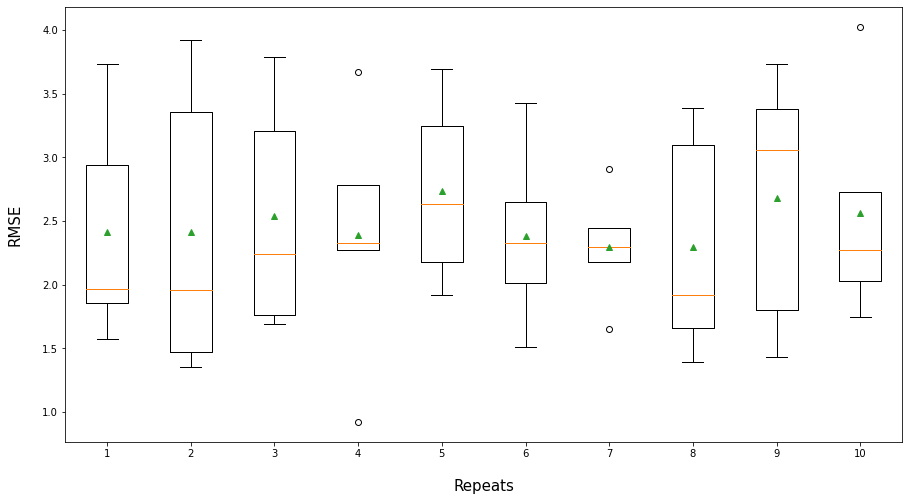

In [53]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [54]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 2.294 (1.342)
RMSE: 2.471 (1.035)
RMSE: 2.398 (1.233)
RMSE: 2.751 (1.072)
RMSE: 2.693 (1.757)
RMSE: 1.664 (0.667)
RMSE: 2.354 (0.983)
RMSE: 2.996 (1.279)
RMSE: 2.650 (1.297)
RMSE: 2.551 (1.364)

RMSE: 2.482 (1.279)


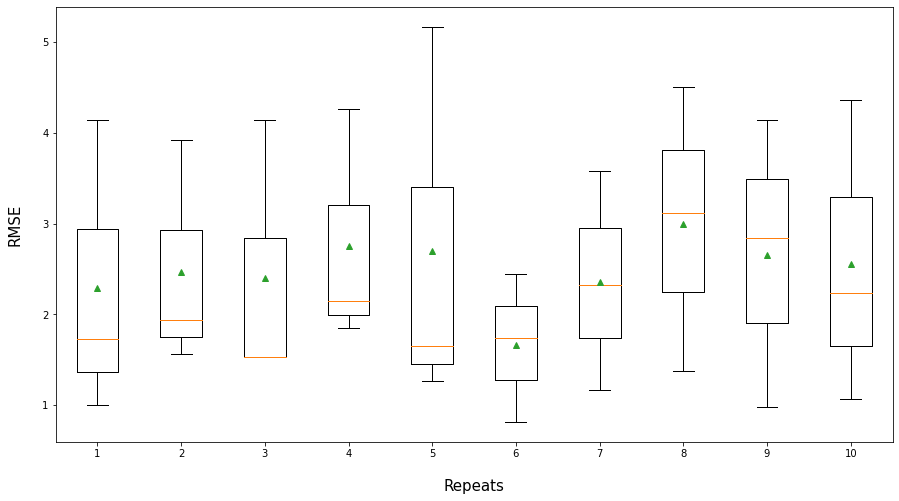

In [55]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [56]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 1.067 (0.000)
RMSE: 2.496 (0.000)
RMSE: 1.275 (0.000)
RMSE: 3.263 (0.000)
RMSE: 1.273 (0.000)
RMSE: 2.037 (0.000)
RMSE: 3.012 (0.000)
RMSE: 2.023 (0.000)
RMSE: 1.246 (0.000)
RMSE: 2.357 (0.000)

RMSE: 2.005 (0.741)


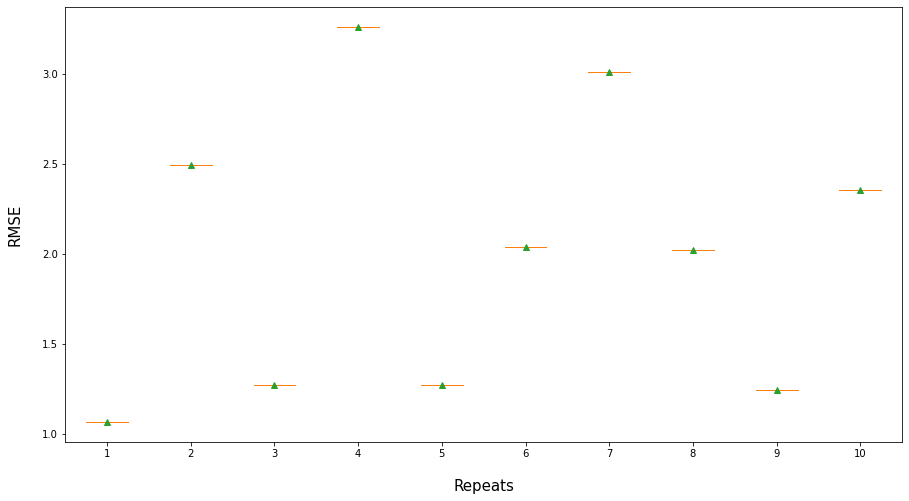

In [57]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_only</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D variable is considered.

In [58]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [59]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 2.221 (0.631)
RMSE: 2.476 (0.705)
RMSE: 2.764 (0.443)
RMSE: 2.058 (0.551)
RMSE: 2.267 (0.457)
RMSE: 2.434 (0.787)
RMSE: 2.617 (0.732)
RMSE: 2.475 (0.674)
RMSE: 1.939 (0.448)
RMSE: 2.517 (0.715)

RMSE: 2.377 (0.671)


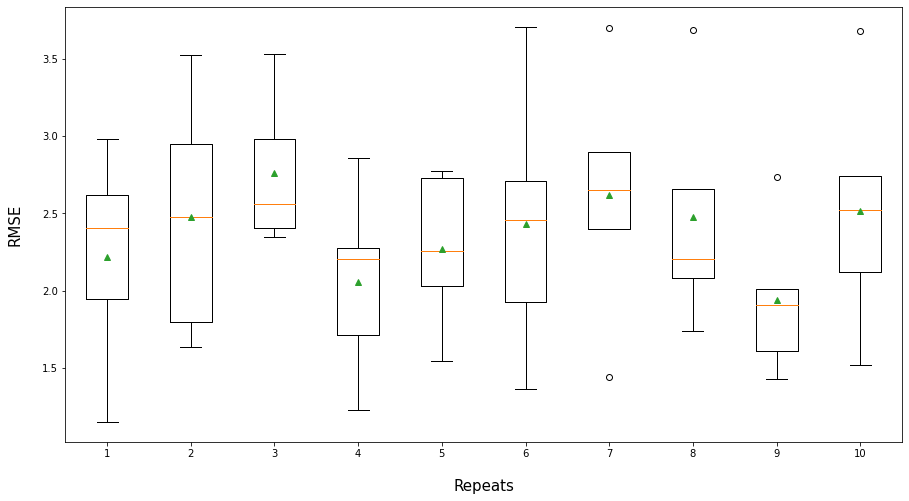

In [60]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [61]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 2.277 (0.588)
RMSE: 2.284 (0.333)
RMSE: 2.289 (1.086)
RMSE: 2.043 (0.856)
RMSE: 2.741 (1.617)
RMSE: 2.121 (1.052)
RMSE: 2.669 (1.229)
RMSE: 1.778 (0.918)
RMSE: 2.366 (1.417)
RMSE: 1.957 (1.236)

RMSE: 2.252 (1.131)


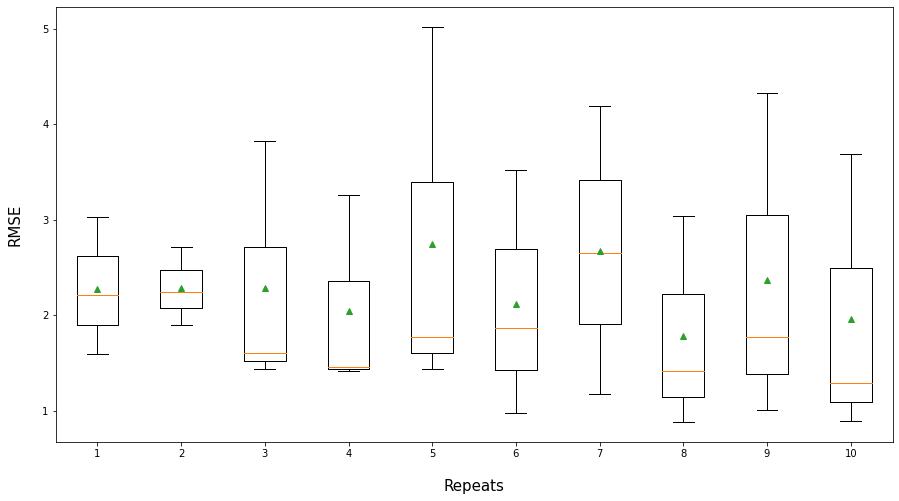

In [62]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [63]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 1.735 (0.000)
RMSE: 1.587 (0.000)
RMSE: 0.790 (0.000)
RMSE: 1.387 (0.000)
RMSE: 1.962 (0.000)
RMSE: 0.739 (0.000)
RMSE: 1.879 (0.000)
RMSE: 2.283 (0.000)
RMSE: 1.406 (0.000)
RMSE: 1.601 (0.000)

RMSE: 1.537 (0.462)


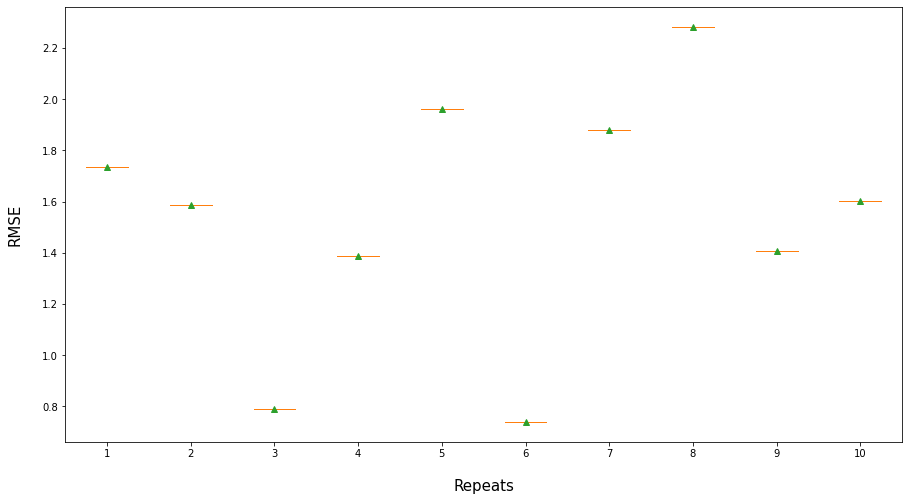

In [64]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_and_r7d</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [65]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [66]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 2.287 (0.868)
RMSE: 2.343 (0.585)
RMSE: 2.379 (0.747)
RMSE: 2.345 (0.506)
RMSE: 2.396 (0.789)
RMSE: 2.347 (0.576)
RMSE: 2.196 (0.499)
RMSE: 2.034 (0.466)
RMSE: 2.225 (0.614)
RMSE: 2.118 (0.848)

RMSE: 2.267 (0.675)


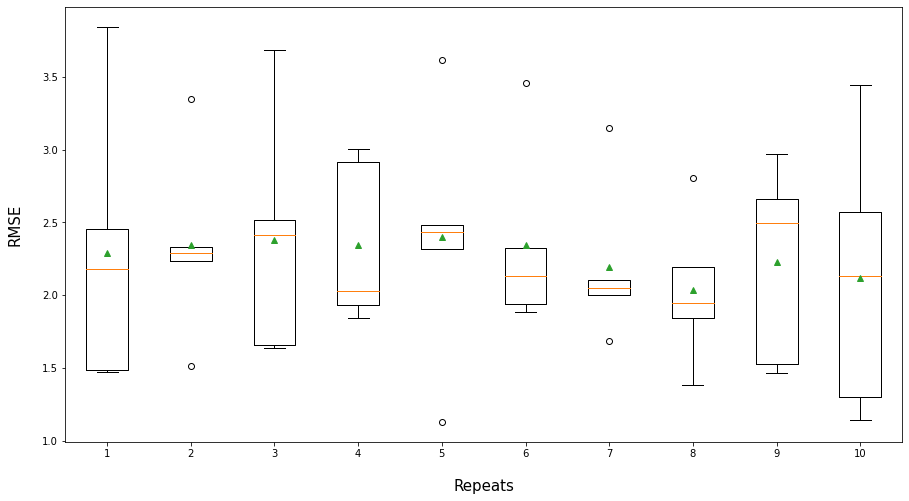

In [67]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [68]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 2.386 (1.601)
RMSE: 2.303 (1.735)
RMSE: 2.406 (0.818)
RMSE: 2.052 (1.467)
RMSE: 2.579 (1.365)
RMSE: 2.391 (1.383)
RMSE: 2.433 (1.575)
RMSE: 1.882 (0.707)
RMSE: 2.500 (1.069)
RMSE: 1.921 (1.209)

RMSE: 2.285 (1.353)


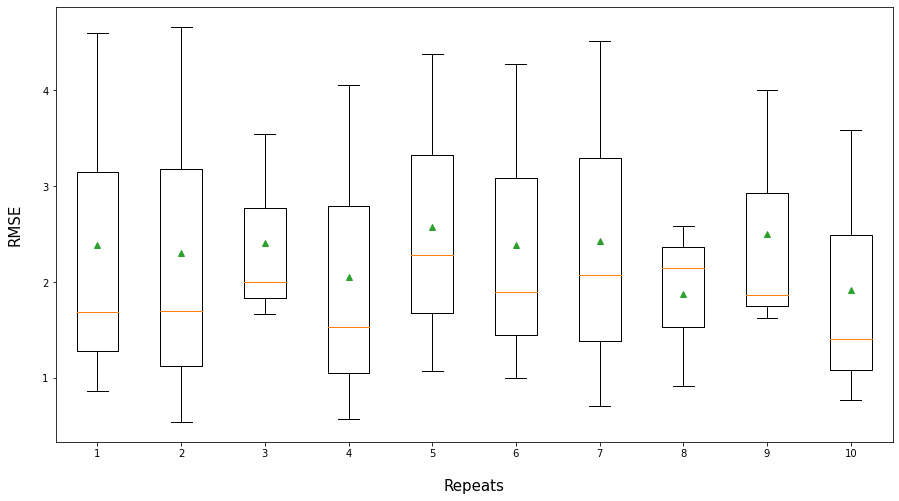

In [69]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [70]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 1.649 (0.000)
RMSE: 1.517 (0.000)
RMSE: 1.226 (0.000)
RMSE: 1.502 (0.000)
RMSE: 1.473 (0.000)
RMSE: 1.731 (0.000)
RMSE: 1.639 (0.000)
RMSE: 1.914 (0.000)
RMSE: 1.145 (0.000)
RMSE: 2.175 (0.000)

RMSE: 1.597 (0.288)


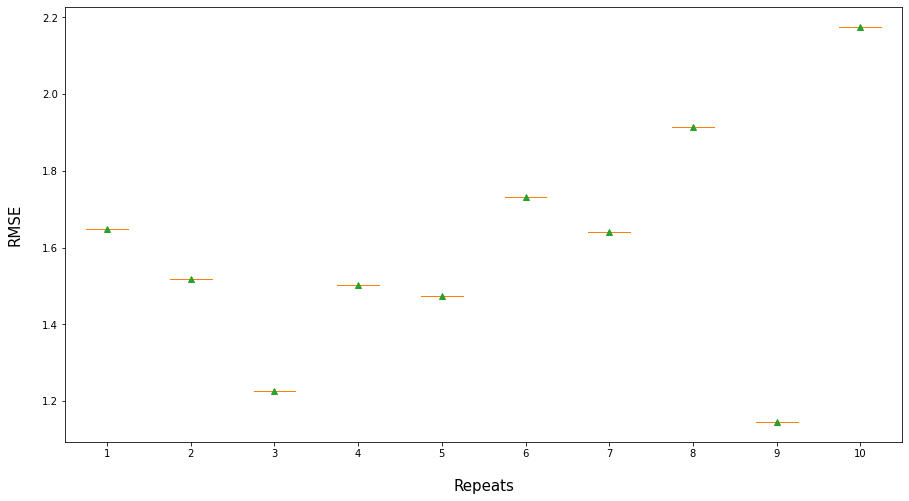

In [71]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

# Times Series Repeated KFold Cross validation - different Timesteps values

Here we will make a Times Series KFold Cross validation with all 3 datasets. Here we are using the Blocking Time Series Split method. And with timeseries Split method. We also do it with different number of timesteps

# Configs:

1. Train Period: [01-01-2019, 2021-05-02)

2. Test Period:  (2021-05-02, 2021-11-31]

3. TIMESTEPS: [1, 3, 5, 7, 10, 15, 20]

4. Epochs: 100

5. Batch size: 32

6. num heads: 2

7. FF Layers enc: 1

      7.1 Units 32

8. Optimization Algorithm: Adam
    
    8.1. Learning Rate: 1e-2

In [72]:
def make_timesteps_repeated_time_series_k_fold(df,
                                               train_period,
                                               test_period,
                                               repeats=10,
                                               timesteps_list=[3],
                                               show_results=True):
    results = {}
    
    for timesteps in timesteps_list:
        x, y = split_sequences(df.values, timesteps)
        scores = make_repeated_time_series_k_fold(x,
                                                  y,
                                                  train_period,
                                                  test_period,
                                                  repeats=10,
                                                  show_individual_results=False,
                                                  show_final_result=False)
        results[timesteps] = scores
        if show_results:
            print('TIMESTEPS: %d RMSE: %.3f (%.3f)' % (timesteps, np.mean(scores), np.std(scores)))
    return results

In [73]:
timesteps_list = [1, 3, 5, 7, 10, 15, 20]
repeats = 10

<h3> Time Series Repeated KFold Cross Validation with vary timesteps - df_no_r3d_r7d</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [74]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [75]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [76]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 2.178 (0.671)
TIMESTEPS: 3 RMSE: 2.337 (0.825)
TIMESTEPS: 5 RMSE: 2.653 (0.859)
TIMESTEPS: 7 RMSE: 2.568 (1.149)
TIMESTEPS: 10 RMSE: 2.439 (0.862)
TIMESTEPS: 15 RMSE: 2.344 (0.708)
TIMESTEPS: 20 RMSE: 2.279 (0.791)


<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [77]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [78]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 2.471 (1.281)
TIMESTEPS: 3 RMSE: 2.405 (1.249)
TIMESTEPS: 5 RMSE: 2.442 (0.986)
TIMESTEPS: 7 RMSE: 2.068 (0.820)
TIMESTEPS: 10 RMSE: 2.939 (0.933)
TIMESTEPS: 15 RMSE: 2.246 (0.893)
TIMESTEPS: 20 RMSE: 2.284 (0.954)


<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [79]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [80]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.609 (0.367)
TIMESTEPS: 3 RMSE: 1.747 (0.683)
TIMESTEPS: 5 RMSE: 2.021 (0.403)
TIMESTEPS: 7 RMSE: 2.171 (0.536)
TIMESTEPS: 10 RMSE: 2.572 (0.781)
TIMESTEPS: 15 RMSE: 3.149 (0.659)
TIMESTEPS: 20 RMSE: 1.362 (0.599)


<h3> Time Series Repeated KFold Cross Validation - df_r3d_only</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D variable is considered.

In [81]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [82]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [83]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.944 (0.668)
TIMESTEPS: 3 RMSE: 2.306 (0.726)
TIMESTEPS: 5 RMSE: 2.530 (0.872)
TIMESTEPS: 7 RMSE: 2.489 (0.888)
TIMESTEPS: 10 RMSE: 2.397 (1.032)
TIMESTEPS: 15 RMSE: 2.330 (0.908)
TIMESTEPS: 20 RMSE: 2.353 (0.838)


<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [84]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [85]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 2.320 (1.213)
TIMESTEPS: 3 RMSE: 2.278 (1.284)
TIMESTEPS: 5 RMSE: 2.326 (1.003)
TIMESTEPS: 7 RMSE: 2.489 (0.755)
TIMESTEPS: 10 RMSE: 2.719 (0.852)
TIMESTEPS: 15 RMSE: 2.396 (0.939)
TIMESTEPS: 20 RMSE: 1.651 (0.570)


<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [86]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [87]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.524 (0.380)
TIMESTEPS: 3 RMSE: 1.922 (0.485)
TIMESTEPS: 5 RMSE: 2.011 (0.688)
TIMESTEPS: 7 RMSE: 2.279 (0.781)
TIMESTEPS: 10 RMSE: 2.305 (0.592)
TIMESTEPS: 15 RMSE: 2.738 (0.887)
TIMESTEPS: 20 RMSE: 1.772 (0.751)


<h3> Time Series Repeated KFold Cross Validation - df_r3d_and_r7d</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [88]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [89]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [90]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 2.062 (0.826)
TIMESTEPS: 3 RMSE: 2.229 (0.638)
TIMESTEPS: 5 RMSE: 2.423 (0.838)
TIMESTEPS: 7 RMSE: 2.414 (0.967)
TIMESTEPS: 10 RMSE: 2.529 (1.045)
TIMESTEPS: 15 RMSE: 2.556 (1.149)
TIMESTEPS: 20 RMSE: 2.460 (0.925)


<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [91]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [92]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 2.291 (1.527)
TIMESTEPS: 3 RMSE: 2.331 (1.266)
TIMESTEPS: 5 RMSE: 2.439 (0.944)
TIMESTEPS: 7 RMSE: 2.278 (0.872)
TIMESTEPS: 10 RMSE: 2.919 (1.052)
TIMESTEPS: 15 RMSE: 2.197 (0.665)
TIMESTEPS: 20 RMSE: 1.877 (0.696)


<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [93]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [94]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.292 (0.246)
TIMESTEPS: 3 RMSE: 1.733 (0.510)
TIMESTEPS: 5 RMSE: 1.751 (0.634)
TIMESTEPS: 7 RMSE: 2.219 (0.533)
TIMESTEPS: 10 RMSE: 2.426 (0.676)
TIMESTEPS: 15 RMSE: 2.028 (0.962)
TIMESTEPS: 20 RMSE: 1.113 (0.427)
